# When Data Representation Matters More than the ML Model
Are you data-centric or model-centric? Here, I explore the impact that a severe class imbalance has on the performance of various machine learning models. 

**By Anthony Lighterness**

04 October 2021

## Table of Contents
1. [Introduction](#1.-Introduction)<br>
2. [Dataset and Context](#2.-Dataset-and-Context)<br>
3. [Import Libraries](#3.-Import-Libraries)<br>
4. [Data Import](#4.-Data-Import)<br>
5. [Cleaning & Wrangling](#5.-Cleaning-&-Wrangling)<br>
6. [Class Balancing & Data Split](#6.-Class-Balancing-&-Data-Split)<br>
7. [Model Experiments](#7.-CNN-Base-Model)<br>
    7.1 [Build](#7.1-Build)<br>
    7.2 [Train](#7.2-Train)<br>
    7.3 [Predict](#7.3-Predict)<br>
    7.4 [Evaluate](#7.4-Evaluate)<br>
8. [Feature Importance](#8.-Feature-Importance)<br>
9. [Results & Discussion](#9.-Results-&-Discussion)<br>
10. [References](#10.-References)<br>

## 1. Introduction

#### What is the *'class imbalance problem'*?
The class imbalance problem presents when a categorical variables, like gender or day of the week, is overrepresented by one class over the other/s. For example, given the gender variable, the possible categories may include, 'male', 'female', and 'other'. A well-balanced dataset will contain equal proportions of each class, but this rarely occurs in the real-world, particularly with gender. One would expect a typical ratio for gender to be 49:49:2, respectively. This may be considered fairly proportional to the population at large, given a 5-10% margin. However, if gender contained 10% male, 89% female, and 1% other, then this would be considered a severe class imbalance. 

An imbalanced categorical variable impacts the performance of a machine learning (ML) model when attempting to learn patterns for classification prediction exercises. Simply put, an ML model may struggle to predict the minority represented class as it develops a bias for learning the over-represented class. We will show a practical example of this when predicting whether or not a diabetes patient will be readmitted to hospital using real-world data. 

#### Why the healthcare-context?
Diabetes mellitus poses a global threat being one of the worlds' most common, life threatening, complex, and costly diseases. Surprisingly, it was noted by Strack et. al. (2014) that inpatient management of diabetes patients can actually be subjective and arbitrary. This is surprising due to the high risk and cost associated with diabetes patients. For example, the diabetes patients are more likely to be readmitted based on a number of unknown factors, thus leading to greater risk to health, quality of life, and greater cost to the hospital and economy at scale. Understanding which factors contribute to the predictability of hospital readmission rates presents the prospect of more objective, data-driven decision making and hospital management of these patients.

Here, we will run and compare the performance metrics of six classification models in duplicate: one using the original, unbalanced dataset, and another on the same dataset balanced using synthetic data by accessing the SMOTE library. 

## 3. Import Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns

#import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


## 4. Data Import

The "*Diabetes 130-US hospitals for years 1999-2008*" dataset was sourced from the UCI website from https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008 and is relatively popular in the literature (Beata et al., 2014; Sharma, 2019; Ranveer, 2020; Chongchong, 2021). While previous work attempted to address the class-imbalance problem, none, to the best of our knowledge, has measured impact pre- and post-balancing to a model's performance. 

<img src='UCI_diab.png' width="600" height="400">

The source website stipulates that each patient record satisfies the following conditions (Beata et al., 2014):

1. Is an inpatient encounter, i.e. a hospital admission.
2. Is a diabetic encounter, that is, one during which any kind of diabetes was entered to the system as a diagnosis.
3. Length of stay (LOS) was at least 1 day and at most 14 days.
4. Laboratory tests were performed during the encounter.
5. Medications were administered during the encounter.

"*The data contains such attributes as patient number, race, gender, age, admission type, time in hospital, medical specialty of admitting physician, number of lab test performed, HbA1c test result, diagnosis, number of medication, diabetic medications, number of outpatient, inpatient, and emergency visits in the year before the hospitalization, etc.*"

In [3]:
df = pd.read_csv("diabetic_data.csv")
df.head(3)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO


## 5. Cleaning & Wrangling

### 5.1 Exploration

##### What does the dataset contain?

In [4]:
# Size of Dataset
df.shape

(101766, 50)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
# Show unique values for each variable
print(df.apply(lambda col: col.unique()))

encounter_id                [2278392, 149190, 64410, 500364, 16680, 35754,...
patient_nbr                 [8222157, 55629189, 86047875, 82442376, 425192...
race                        [Caucasian, AfricanAmerican, ?, Other, Asian, ...
gender                                        [Female, Male, Unknown/Invalid]
age                         [[0-10), [10-20), [20-30), [30-40), [40-50), [...
weight                      [?, [75-100), [50-75), [0-25), [100-125), [25-...
admission_type_id                                    [6, 1, 2, 3, 4, 5, 8, 7]
discharge_disposition_id    [25, 1, 3, 6, 2, 5, 11, 7, 10, 4, 14, 18, 8, 1...
admission_source_id         [1, 7, 2, 4, 5, 6, 20, 3, 17, 8, 9, 14, 10, 22...
time_in_hospital              [1, 3, 2, 4, 5, 13, 12, 9, 7, 10, 6, 11, 8, 14]
payer_code                  [?, MC, MD, HM, UN, BC, SP, CP, SI, DM, CM, CH...
medical_specialty           [Pediatrics-Endocrinology, ?, InternalMedicine...
num_lab_procedures          [41, 59, 11, 44, 51, 31, 70, 73, 68,

##### Missing Values
It appears that "?" and "Missing" values are present in the data. These must be changed to proper numpy NaN values.

In [7]:
# Replace "?" values with missing/NaN values
df2 = df.copy()
df2 = df2.replace('?', np.NaN)
df3 = df2.copy()
df3['medical_specialty'] = df3['medical_specialty'].replace(np.NaN, 'Missing', regex=True)

# Check sum of missing/null values
df3.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

It seems that six data items contain missing values, of which the greatest concerns are 'weight' and potentially 'payer code'.

### 5.2 Remove Duplicate Patients
Following on from the official report by Strack et al. (2014), we are only interested in patients' first encounter. Therefore, we sort by patient number, and remove subsequent/duplicate records. 

In [8]:
df4 = df3.copy()
# Sort by patient number
df4_sort = df4.sort_values(by='patient_nbr')
df4_sort.head(4)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
4267,24437208,135,Caucasian,Female,[50-60),NaN,2,1,1,8,...,No,Steady,No,No,No,No,No,Ch,Yes,<30
4780,26264286,135,Caucasian,Female,[50-60),NaN,1,1,7,3,...,No,No,No,No,No,No,No,Ch,Yes,>30
5827,29758806,378,Caucasian,Female,[50-60),NaN,3,1,1,2,...,No,No,No,No,No,No,No,No,No,NO
67608,189899286,729,Caucasian,Female,[80-90),NaN,1,3,7,4,...,No,No,No,No,No,No,No,No,Yes,NO


In [9]:
df5 = df4_sort.copy()
# Remove duplicate records
df6 = df5.drop_duplicates(subset='patient_nbr', keep="last")

In [9]:
print("Original Shape:", df.shape)
print("New Shape:", df6.shape)

Original Shape: (101766, 50)
New Shape: (71518, 50)


### 5.3 Clean 'Discharge Disposition'
Following from Strack et al. (2014), we will remove all encounters that resulted in either discharge to a hospice or patient death. 
- Remove discharges to hospice and deaths
- Discharge Codes relevant:
    - 11 = 'expired'
    - 13 = 'hospice/home'
    - 14 = 'hospice/medical facility'
    - 19 = 'expired at home' 
    - 20 = 'expired in medical facility'
    - 21 = 'exired, place unknown'


In [10]:
df6['discharge_disposition_id'].unique()

array([ 1,  3,  6,  5,  2, 25, 22, 18, 11, 13, 14,  4,  7,  8, 23, 15, 12,
       17, 16, 28, 24, 27,  9, 19, 10, 20])

In [11]:
# count occurances a particular column
display(df6.groupby(['discharge_disposition_id']).size().sort_values(ascending=False))
# 1: 43878, #3: 9051, #6: 8405

display(df6.groupby(['admission_source_id']).size().sort_values(ascending=False))

display(df6.groupby(['race']).size())
display(df6.groupby(['gender']).size())


discharge_disposition_id
1     43878
3      9051
6      8405
18     2473
2      1491
22     1339
11     1299
5       871
25      647
4       554
7       418
13      295
23      276
14      258
28       83
8        68
15       39
24       27
9        13
17       10
19        7
10        6
16        4
27        3
12        2
20        1
dtype: int64

admission_source_id
7     38598
1     21690
17     4919
4      2614
6      1809
2       900
5       595
20      143
3       124
9        97
8        10
10        6
22        6
11        2
14        2
25        2
13        1
dtype: int64

race
AfricanAmerican    12903
Asian                502
Caucasian          53516
Hispanic            1518
Other               1170
dtype: int64

gender
Female             38024
Male               33491
Unknown/Invalid        3
dtype: int64

Drop records with discharge disposition 11, 13, 14, 20, or 21.

In [12]:
df7 = df6.copy()
df8 = df7[~((df7['discharge_disposition_id'] == 11) |
            (df7['discharge_disposition_id'] == 13) |
           (df7['discharge_disposition_id'] == 14) |
           (df7['discharge_disposition_id'] == 20) |
           (df7['discharge_disposition_id'] == 21))]


In [13]:
# sanity check
print("Sanity Check:")
print("Original Discharge Dispositions:",
        df6['discharge_disposition_id'].unique())
print("Post-Removed Discharge Dispositions:",
        df8['discharge_disposition_id'].unique())

Sanity Check:
Original Discharge Dispositions: [ 1  3  6  5  2 25 22 18 11 13 14  4  7  8 23 15 12 17 16 28 24 27  9 19
 10 20]
Post-Removed Discharge Dispositions: [ 1  3  6  5  2 25 22 18  4  7  8 23 15 12 17 16 28 24 27  9 19 10]


### 5.4 Consolidate ICD Codes, Medical Specialties, and Readmission
As per Strack et al. (2014), we will group the primary ICD diagnoses into the following groups to simplify the analysis. 

##### Primary Diagnosis ICD Grouping ID's
-	1: Circulatory: 390-459, 785
-	2: Respiratory: 460-519, 786
-	3: Digestive: 520-579, 787
-	4: Diabetes: 250.xx
-	5: Injury: 800-999
-	6: Musculoskeletal: 710-739
-	7: Genitourinary: 580-629, 788
-   8: Neoplasms: 
    * Neoplasms: 140-239 
    * Other Symptoms: 780, 781, 784, 790-799
    * Endocrine: 240-279, without 250
    * Skin: 680-709, 782
    * Infectious: 001-319

- 9: Other 
    * Mental: 290-319
    * External: E-V
    * Blood: 280-289
    * Nervous: 320-359
    * Pregnancy: 630-679
    * Sense: 360-389
    * Congenital: 740-759


In [14]:
# Function for Grouping Primary Diagnosis
def label_diag_1(col):
    if (col >= 390 and col <=459) or col == 785:
        diag = 'Circulatory'
    elif (col >= 460 and col <=519) or col == 786:
        diag = 'Respiratory'
    elif (col >= 520 and col <= 579) or col == 787:
        diag = 'Digestive'
    elif col == 250:
        diag = 'Diabetes'
    elif (col >=800 and col <=999):
        diag = 'Injury'
    elif (col >= 710 and col <=739):
        diag = 'MSK'
    elif (col >= 580 and col <= 629) or (col==788):
        diag = 'GenitoUrinary'
    else:
        diag = 'Other'
    return diag

# Function to group medical_specialties into common groups/domains: 
# 1.'GeneralPrac': ['Family/GeneralPractice']
# 2.'IntMed': ['InternalMedicine', 'Hospitalist', 'Resident']
# 3.'Missing': ['Missing', 'PhysicianNotFound']
# 4.'Surgery': ['Surgery-x', 'SurgicalSpecialty', 'Surgeon']
# 5.'CVD': ['Cardiology', 'x-Vascular', 'x-Thoracic']
# 6.'Respiratory': ['Pulmonology']
# 7.'Pediatrics': ['Pediatrics-x', 'x-Pediatric', 'Pediatrics']
# 8.'RenalEndocrin': ['Nephrology', 'Endocrinology', 'Urology', 'Endocrinology-Metabolism']
# 9. 'Other': the rest

# Function to group physician's specialties 
def Label_MedSpec_Group (col):
    if col == 'Family/GeneralPractice':
        spec = 'GeneralPrac'
    elif col == 'Pulmonology':
        spec = 'Respiratory'
    elif col == 'Cardiology':
        spec = 'CVD'
    elif col == 'Missing':
        spec = 'Missing'
    elif col == 'PhysicianNotFound':
        spec = 'Missing'
    else:
        spec = 'Other'
    return spec

# Function to group Discharge Disposition into "1: Home" or "2: Other"
def discharge_group(col):
    if col == 1:
        dis = 'Home'
    else:
        dis = 'Other'
    return dis

# Function to group admission source id: 
def ADM_source_group(col):
    if col == 7:
        adm = 'ER'
    elif (col == 1 or col == 2 or col == 3):
        adm = 'Referral'
    else:
        adm = 'Other'
    return adm

# group 'readmitted' as "ReADM": 0 = ">30" & "NO" and 1 = "<30"
def reADM_group(col):
    if col == "<30":
        readm = 1
    else:
        readm = 0
    return readm

# create new variable 0,1 for is_A1C_measured (i.e. if "none" = "0", else = "1")
def is_A1C_result(col):
    if col == "None":
        A1C = 0
    else:
        A1C = 1
    return A1C


In [15]:
df10 = df8.copy()
df11 = df10.copy()
# remove "V" and "E" for INT coercion
df11['diag_1'] = df11['diag_1'].str.replace('V','')
df11['diag_1'] = df11['diag_1'].str.replace('E','')

# replace NaN values as 0 for INT coercion
df11['diag_1'] = df11['diag_1'].replace(np.NaN, '0', regex=True)

# coerce as INT type
df11['diag_1'] = df11['diag_1'].astype(float).astype(int)


#### Apply the User-Defined Functions to the Dataset

In [16]:
# Apply grouping functions to DF
df12 = df11.copy()

# Medical Specialty Groupings
df12['MedSpec'] = df11['medical_specialty'].apply(lambda x: Label_MedSpec_Group(x))

df13 = df12.copy()
df13.loc[df13['medical_specialty'].str.contains("Surg"),'MedSpec'] = 'Surgery'
df13.loc[df13['medical_specialty'].str.contains("Internal|Resident|Hospit"),'MedSpec'] = 'InternalMedicine'
df13.loc[df13['medical_specialty'].str.contains("Pediat"),'MedSpec'] = 'Pediatric'
df13.loc[df13['medical_specialty'].str.contains("Nephr|Endocrin|Urol"),'MedSpec'] = 'RenalEndocrin'

df14 = df13.copy()

# Diag_1 Groupings
df14['Diag1'] = df13['diag_1'].apply(lambda x: label_diag_1(x))

# Discharge Disposition Grouping
df14['DischDisp'] = df13['discharge_disposition_id'].apply(lambda x: discharge_group(x))

# Admission Source ID Grouping
df14['ADM_Source'] = df13['admission_source_id'].apply(lambda x: ADM_source_group(x))

# Group Readmissions
df14['ReADM'] = df13['readmitted'].apply(lambda x: reADM_group(x))

# Is A1C measured?
df14['A1C_is_meas'] = df13['A1Cresult'].apply(lambda x: is_A1C_result(x))


In [17]:
# Check Grouping Value Counts
print(df14.groupby(['Diag1']).size())

display(df14.groupby(['MedSpec']).size())

display(df14.groupby(['DischDisp']).size())

display(df14.groupby(['ADM_Source']).size())

display(df14.groupby(['ReADM']).size())

display(df14.groupby(['A1C_is_meas']).size())


Diag1
Circulatory      21024
Diabetes          5674
Digestive         6516
GenitoUrinary     3483
Injury            4762
MSK               3945
Other            14793
Respiratory       9468
dtype: int64


MedSpec
CVD                  4160
GeneralPrac          4861
InternalMedicine    10697
Missing             33482
Other               10161
Pediatric             311
RenalEndocrin        1589
Respiratory           644
Surgery              3760
dtype: int64

DischDisp
Home     43878
Other    25787
dtype: int64

ADM_Source
ER          37371
Other        9925
Referral    22369
dtype: int64

ReADM
0    64614
1     5051
dtype: int64

A1C_is_meas
0    57193
1    12472
dtype: int64

### 5.5 One-Hot-Encoding
One-hot-encoding makes categorical variables ingestible for ML models, e.g. "0=Male" and "1=Female", or vice versa.

##### Columns to Keep and OHE: 
'race', 'gender', 'age',
'admission_type_id', 'time_in_hospital', 'payer_code',
'num_lab_procedures', 'num_procedures', 'num_medications',
'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses',
'max_glu_serum', 'A1Cresult',
'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 
'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed'
'MedSpec', 'Diag1', 'DischDisp', 'ADM_Source', 'ReADM', 'A1C_is_meas'


In [18]:
df15 = df14.copy()

cols_keep = ['race', 'gender', 'age','time_in_hospital',
              'num_lab_procedures', 'num_procedures', 'num_medications','number_outpatient', 
              'number_emergency', 'number_inpatient', 'number_diagnoses','max_glu_serum', 'A1Cresult',
              'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
              'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol',
              'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 
              'glipizide-metformin','glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 
              'change', 'diabetesMed','MedSpec', 'Diag1', 'DischDisp', 'ADM_Source', 'A1C_is_meas', 'ReADM']

df16 = df15[cols_keep]


In [19]:
# Sanity Check
df16.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'MedSpec', 'Diag1',
       'DischDisp', 'ADM_Source', 'A1C_is_meas', 'ReADM'],
      dtype='object')

In [20]:
# OHE Get Dummies
# Drop first = True to omit redundant OHE columns, e.g. when Female=1, you don't also need Male=0. 
df17 = pd.get_dummies(df16, drop_first=True)

In [21]:
# Re-order columns
df17 = df17[['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'A1C_is_meas',
       'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Other',
       'gender_Male', 'gender_Unknown/Invalid', 'age_[10-20)', 'age_[20-30)',
       'age_[30-40)', 'age_[40-50)', 'age_[50-60)', 'age_[60-70)',
       'age_[70-80)', 'age_[80-90)', 'age_[90-100)', 'max_glu_serum_>300',
       'max_glu_serum_None', 'max_glu_serum_Norm', 'A1Cresult_>8',
       'A1Cresult_None', 'A1Cresult_Norm', 'metformin_No', 'metformin_Steady',
       'metformin_Up', 'repaglinide_No', 'repaglinide_Steady',
       'repaglinide_Up', 'nateglinide_No', 'nateglinide_Steady',
       'nateglinide_Up', 'chlorpropamide_No', 'chlorpropamide_Steady',
       'chlorpropamide_Up', 'glimepiride_No', 'glimepiride_Steady',
       'glimepiride_Up', 'acetohexamide_Steady', 'glipizide_No',
       'glipizide_Steady', 'glipizide_Up', 'glyburide_No', 'glyburide_Steady',
       'glyburide_Up', 'tolbutamide_Steady', 'pioglitazone_No',
       'pioglitazone_Steady', 'pioglitazone_Up', 'rosiglitazone_No',
       'rosiglitazone_Steady', 'rosiglitazone_Up', 'acarbose_No',
       'acarbose_Steady', 'acarbose_Up', 'miglitol_No', 'miglitol_Steady',
       'miglitol_Up', 'troglitazone_Steady', 'tolazamide_Steady', 'insulin_No',
       'insulin_Steady', 'insulin_Up', 'glyburide-metformin_No',
       'glyburide-metformin_Steady', 'glyburide-metformin_Up',
       'glipizide-metformin_Steady', 'glimepiride-pioglitazone_Steady',
       'metformin-rosiglitazone_Steady', 'metformin-pioglitazone_Steady',
       'change_No', 'diabetesMed_Yes', 'MedSpec_GeneralPrac',
       'MedSpec_InternalMedicine', 'MedSpec_Missing', 'MedSpec_Other',
       'MedSpec_Pediatric', 'MedSpec_RenalEndocrin', 'MedSpec_Respiratory',
       'MedSpec_Surgery', 'Diag1_Diabetes', 'Diag1_Digestive',
       'Diag1_GenitoUrinary', 'Diag1_Injury', 'Diag1_MSK', 'Diag1_Other',
       'Diag1_Respiratory', 'DischDisp_Other', 'ADM_Source_Other',
       'ADM_Source_Referral','ReADM']]


##### Quick View of Dataset

In [22]:
display(df17.head(3))
display(df17.tail(3))


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1C_is_meas,race_Asian,...,Diag1_Digestive,Diag1_GenitoUrinary,Diag1_Injury,Diag1_MSK,Diag1_Other,Diag1_Respiratory,DischDisp_Other,ADM_Source_Other,ADM_Source_Referral,ReADM
4780,3,31,1,14,0,0,1,5,0,0,...,0,0,1,0,0,0,0,0,0,0
5827,2,49,1,11,0,0,0,3,0,0,...,0,0,0,1,0,0,0,0,1,0
67608,4,68,2,23,0,0,0,9,1,0,...,0,0,1,0,0,0,1,0,0,0


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1C_is_meas,race_Asian,...,Diag1_Digestive,Diag1_GenitoUrinary,Diag1_Injury,Diag1_MSK,Diag1_Other,Diag1_Respiratory,DischDisp_Other,ADM_Source_Other,ADM_Source_Referral,ReADM
93651,3,39,0,18,0,0,0,9,0,0,...,0,0,0,0,0,1,0,0,0,0
101748,14,69,0,16,0,0,0,5,1,0,...,0,0,0,0,1,0,1,0,0,0
96147,5,35,4,23,0,0,0,8,0,0,...,1,0,0,0,0,0,0,0,1,0


In [23]:
display(df17.apply(lambda col: col.unique()))


time_in_hospital         [3, 2, 4, 5, 6, 9, 1, 14, 12, 8, 7, 13, 10, 11]
num_lab_procedures     [31, 49, 68, 46, 45, 52, 47, 21, 57, 50, 44, 7...
num_procedures                                     [1, 2, 0, 4, 5, 6, 3]
num_medications        [14, 11, 23, 20, 5, 15, 16, 12, 18, 31, 9, 13,...
number_outpatient      [0, 3, 1, 5, 4, 2, 15, 27, 13, 8, 16, 6, 25, 1...
                                             ...                        
Diag1_Respiratory                                                 [0, 1]
DischDisp_Other                                                   [0, 1]
ADM_Source_Other                                                  [0, 1]
ADM_Source_Referral                                               [0, 1]
ReADM                                                             [0, 1]
Length: 98, dtype: object

In [24]:
display(df17.iloc[0:3,0:10])
display(df17.iloc[0:3,11:20])
display(df17.iloc[0:3,21:30])
display(df17.iloc[0:3,31:40])
display(df17.iloc[0:3,41:50])
display(df17.iloc[0:3,51:60])
display(df17.iloc[0:3,61:70])
display(df17.iloc[0:3,71:80])
display(df17.iloc[0:3,81:90])
display(df17.iloc[0:3,91:98])


,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1C_is_meas,race_Asian
4780,3,31,1,14,0,0,1,5,0,0
5827,2,49,1,11,0,0,0,3,0,0
67608,4,68,2,23,0,0,0,9,1,0


,race_Hispanic,race_Other,gender_Male,gender_Unknown/Invalid,age_[10-20),age_[20-30),age_[30-40),age_[40-50),age_[50-60)
4780,0,0,0,0,0,0,0,0,1
5827,0,0,0,0,0,0,0,0,1
67608,0,0,0,0,0,0,0,0,0


,age_[70-80),age_[80-90),age_[90-100),max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1Cresult_>8,A1Cresult_None,A1Cresult_Norm
4780,0,0,0,0,1,0,0,1,0
5827,0,0,0,0,1,0,0,1,0
67608,0,1,0,0,1,0,0,0,0


,metformin_Steady,metformin_Up,repaglinide_No,repaglinide_Steady,repaglinide_Up,nateglinide_No,nateglinide_Steady,nateglinide_Up,chlorpropamide_No
4780,1,0,1,0,0,1,0,0,1
5827,0,0,1,0,0,1,0,0,1
67608,1,0,1,0,0,1,0,0,1


,chlorpropamide_Up,glimepiride_No,glimepiride_Steady,glimepiride_Up,acetohexamide_Steady,glipizide_No,glipizide_Steady,glipizide_Up,glyburide_No
4780,0,1,0,0,0,1,0,0,0
5827,0,1,0,0,0,1,0,0,1
67608,0,1,0,0,0,1,0,0,1


,glyburide_Up,tolbutamide_Steady,pioglitazone_No,pioglitazone_Steady,pioglitazone_Up,rosiglitazone_No,rosiglitazone_Steady,rosiglitazone_Up,acarbose_No
4780,0,0,1,0,0,1,0,0,1
5827,0,0,1,0,0,1,0,0,1
67608,0,0,1,0,0,1,0,0,1


,acarbose_Up,miglitol_No,miglitol_Steady,miglitol_Up,troglitazone_Steady,tolazamide_Steady,insulin_No,insulin_Steady,insulin_Up
4780,0,1,0,0,0,0,1,0,0
5827,0,1,0,0,0,0,1,0,0
67608,0,1,0,0,0,0,1,0,0


,glyburide-metformin_Steady,glyburide-metformin_Up,glipizide-metformin_Steady,glimepiride-pioglitazone_Steady,metformin-rosiglitazone_Steady,metformin-pioglitazone_Steady,change_No,diabetesMed_Yes,MedSpec_GeneralPrac
4780,0,0,0,0,0,0,0,1,0
5827,0,0,0,0,0,0,1,0,0
67608,0,0,0,0,0,0,1,1,0


,MedSpec_Missing,MedSpec_Other,MedSpec_Pediatric,MedSpec_RenalEndocrin,MedSpec_Respiratory,MedSpec_Surgery,Diag1_Diabetes,Diag1_Digestive,Diag1_GenitoUrinary
4780,0,0,0,0,0,1,0,0,0
5827,0,0,0,0,0,1,0,0,0
67608,0,0,0,0,0,0,0,0,0


,Diag1_MSK,Diag1_Other,Diag1_Respiratory,DischDisp_Other,ADM_Source_Other,ADM_Source_Referral,ReADM
4780,0,0,0,0,0,0,0
5827,1,0,0,0,0,1,0
67608,0,0,0,1,0,0,0


### 5.6 Correlation Analysis

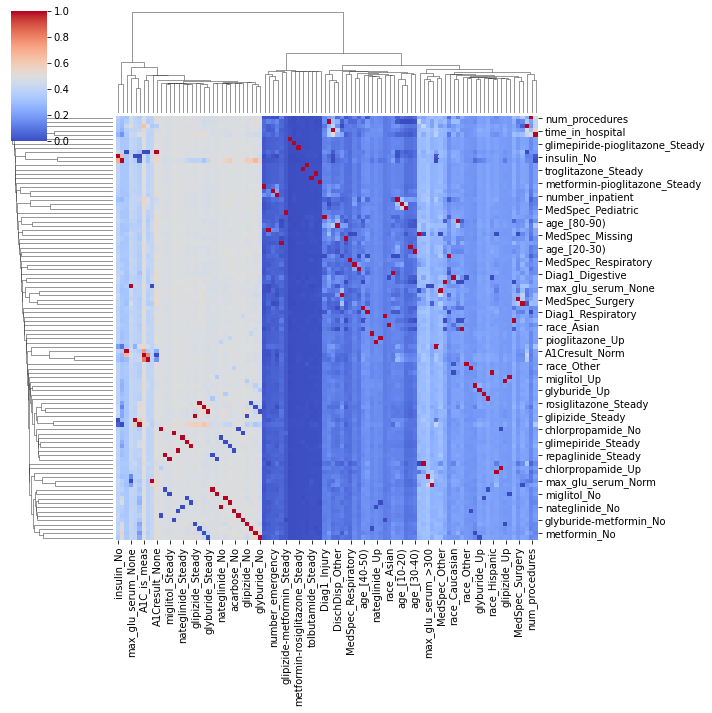

In [25]:
sns.clustermap(df17.corr(), cmap="coolwarm", standard_scale = 1)


In [26]:
df18 = df17.copy()

In [27]:
# Rename Age Group Classes
df18 = df18.rename(columns={"age_[10-20)":"age_10-20","age_[20-30)":"age_20-30",
                            "age_[30-40)":"age_30-40",
                            "age_[40-50)":"age_40-50","age_[50-60)":"age_50-60",
                            "age_[60-70)":"age_60-70","age_[70-80)":"age_70-80",
                            "age_[80-90)":"age_80-90","age_[90-100)":"age_90-100",
                           "A1Cresult_>8":"A1Cresult_8+", 
                            "max_glu_serum_>300":"max_glu_serum_300+"})
df18.columns

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'A1C_is_meas', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other', 'gender_Male',
       'gender_Unknown/Invalid', 'age_10-20', 'age_20-30', 'age_30-40',
       'age_40-50', 'age_50-60', 'age_60-70', 'age_70-80', 'age_80-90',
       'age_90-100', 'max_glu_serum_300+', 'max_glu_serum_None',
       'max_glu_serum_Norm', 'A1Cresult_8+', 'A1Cresult_None',
       'A1Cresult_Norm', 'metformin_No', 'metformin_Steady', 'metformin_Up',
       'repaglinide_No', 'repaglinide_Steady', 'repaglinide_Up',
       'nateglinide_No', 'nateglinide_Steady', 'nateglinide_Up',
       'chlorpropamide_No', 'chlorpropamide_Steady', 'chlorpropamide_Up',
       'glimepiride_No', 'glimepiride_Steady', 'glimepiride_Up',
       'acetohexamide_Steady', 'glipizide_No', 'glipizide_Steady',
       'glipizide_Up', 'glyburide_

In [28]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.light_palette((250, 100, 50), input="husl", n_colors=50).as_hex())
table = df18.corr(method='pearson')
table.style.background_gradient(cmap=cmap, axis = 0)


In [29]:
os.getcwd()

'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal'

In [30]:
# Output and Save Current Dataset
df18.to_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/df18.csv')


### 5.7 Visualise Distributions

Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

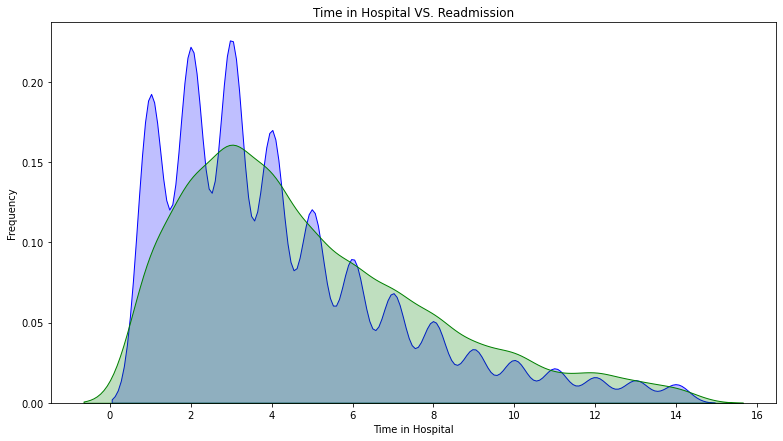

In [31]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(df18.loc[(df18['ReADM'] == 0),'time_in_hospital'],
               color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(df18.loc[(df18['ReADM'] == 1),'time_in_hospital'], 
               color='g',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Frequency Count of Readmissions')

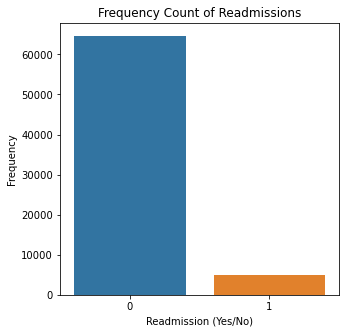

In [32]:
fig = plt.figure(figsize=(5,5),)
ax=sns.countplot(df18['ReADM'])
ax.set(xlabel='Readmission (Yes/No)', ylabel='Frequency')
plt.title('Frequency Count of Readmissions')

/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Diabetes Medication prescribed VS Readmission')

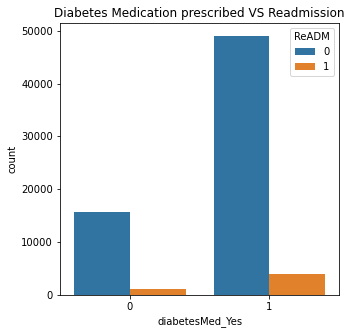

In [33]:
fig = plt.figure(figsize=(5,5))
sns.countplot(df18['diabetesMed_Yes'], 
              hue = df18['ReADM']).set_title('Diabetes Medication prescribed VS Readmission')

Text(0.5, 1.0, 'Number of lab procedure VS. Readmission')

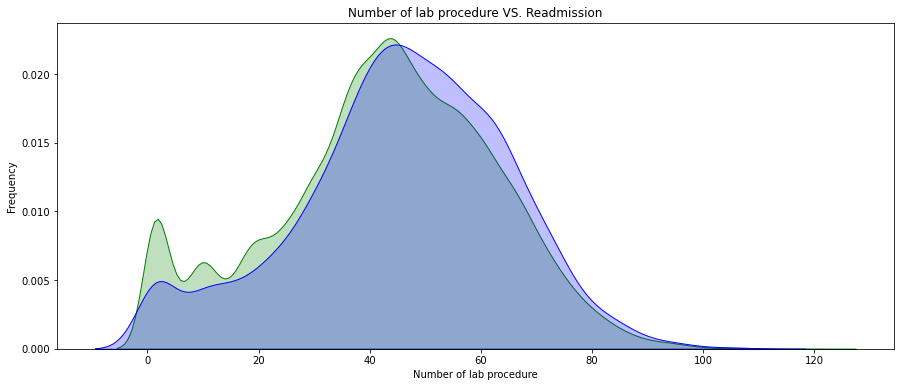

In [34]:
fig = plt.figure(figsize=(15,6),)
ax=sns.kdeplot(df18.loc[(df18['ReADM'] == 0),'num_lab_procedures'], 
               color='g',shade=True,label='Not readmitted')
ax=sns.kdeplot(df18.loc[(df18['ReADM'] == 1),'num_lab_procedures'], 
               color='b',shade=True, label='readmitted')
ax.set(xlabel='Number of lab procedure', ylabel='Frequency')
plt.title('Number of lab procedure VS. Readmission')

In [35]:
df19=df18.copy()

In [36]:
df19.head(1)

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1C_is_meas,race_Asian,...,Diag1_Digestive,Diag1_GenitoUrinary,Diag1_Injury,Diag1_MSK,Diag1_Other,Diag1_Respiratory,DischDisp_Other,ADM_Source_Other,ADM_Source_Referral,ReADM
4780,3,31,1,14,0,0,1,5,0,0,...,0,0,1,0,0,0,0,0,0,0


## 6. Class Balancing & Data Split

Here we use SMOTE from imblearn to create synthetic data for balancing Readmission rate.

In [37]:
df20 = df19.copy()

In [38]:
#conda install -c conda-forge imbalanced-learn
from imblearn.over_sampling import SMOTE, ADASYN

X = df20.iloc[:, 0:97]
y = df20.iloc[:, 97:98]

X_resampled, y_resampled = SMOTE().fit_resample(X, y)

X = X_resampled
y = y_resampled

print(X.shape)
print(y.shape)
df21 = np.concatenate((X, y),axis=1)
df21 = pd.DataFrame(df21)
df21.shape

(129228, 97)
(129228, 1)


(129228, 98)

/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-39-cf894dc94ae8>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


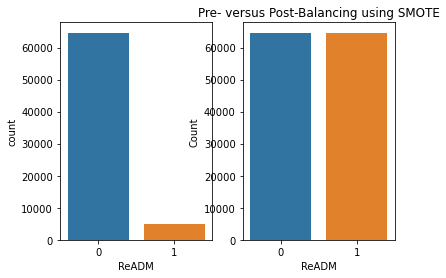

In [39]:
labels = ['0','1']
fig, ax = plt.subplots(1,2)

sns.countplot(df18['ReADM'], ax=ax[0])
#plt.title("Pre- versus Post-Balancing using SMOTE")
plt.ylabel("Count")

sns.countplot(df21.iloc[:,97], ax=ax[1])
plt.xlabel("ReADM")
plt.ylabel("Count")
plt.title("Pre- versus Post-Balancing using SMOTE")
fig.show()


In [40]:
df_bal = df21.copy()
df_imbal = df18.copy()

In [107]:
df_imbal

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1C_is_meas,race_Asian,...,Diag1_Digestive,Diag1_GenitoUrinary,Diag1_Injury,Diag1_MSK,Diag1_Other,Diag1_Respiratory,DischDisp_Other,ADM_Source_Other,ADM_Source_Referral,ReADM
4780,3,31,1,14,0,0,1,5,0,0,...,0,0,1,0,0,0,0,0,0,0
5827,2,49,1,11,0,0,0,3,0,0,...,0,0,0,1,0,0,0,0,1,0
67608,4,68,2,23,0,0,0,9,1,0,...,0,0,1,0,0,0,1,0,0,0
17494,3,46,0,20,0,0,0,9,1,0,...,0,0,0,0,1,0,0,0,0,0
2270,5,49,0,5,0,0,0,3,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99863,1,73,1,11,0,0,0,9,0,0,...,0,0,0,0,1,0,0,0,0,0
95282,3,56,1,8,0,0,0,7,0,0,...,0,1,0,0,0,0,0,0,0,0
93651,3,39,0,18,0,0,0,9,0,0,...,0,0,0,0,0,1,0,0,0,0
101748,14,69,0,16,0,0,0,5,1,0,...,0,0,0,0,1,0,1,0,0,0


In [106]:
df_bal

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
0,3,31,1,14,0,0,1,5,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2,49,1,11,0,0,0,3,0,0,...,0,0,0,1,0,0,0,0,1,0
2,4,68,2,23,0,0,0,9,1,0,...,0,0,1,0,0,0,1,0,0,0
3,3,46,0,20,0,0,0,9,1,0,...,0,0,0,0,1,0,0,0,0,0
4,5,49,0,5,0,0,0,3,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129223,4,45,1,19,0,0,0,9,0,0,...,0,0,0,0,0,0,0,0,1,1
129224,4,57,0,11,0,0,1,9,0,0,...,0,0,0,0,1,0,0,0,0,1
129225,9,36,2,9,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,1
129226,2,61,0,21,0,0,0,8,1,0,...,0,0,0,0,0,1,0,0,0,1


In [51]:
# Datasets Checkpoint for Export/Import
#df_bal.to_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/df_bal.csv')
#df_imbal.to_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/df_imbal.csv')


In [ ]:
# Import
df_bal = pd.read_csv("df_bal.csv")
df_imbal = pd.read_csv("df_imbal.csv")


### 6.2 Data Split: Training, Testing, Validation

In [41]:
from sklearn.model_selection import train_test_split

# Test, Train, Valilation Splits for ReADM Class Balanced Dataset
train_bal, test_bal = train_test_split(df_bal, test_size=0.2,
                                         random_state=123)
val_bal, test_bal = train_test_split(test_bal, test_size=0.5,
                                             random_state=123)

# Now for Imbalanced Class Dataset

train_imbal, test_imbal = train_test_split(df_imbal, test_size=0.2,
                                         random_state=123)
val_imbal, test_imbal = train_test_split(test_imbal, test_size=0.5,
                                             random_state=123)


In [42]:
print("Shapes of Data Subsets")
print("Train_bal:", train_bal.shape)
print("Train_imbal:", train_imbal.shape)
print("Test_bal:", train_bal.shape)
print("Test_imbal:", train_imbal.shape)
print("Val_bal:", train_bal.shape)
print("Val_imbal:", train_imbal.shape)


Shapes of Data Subsets
Train_bal: (103382, 98)
Train_imbal: (55732, 98)
Test_bal: (103382, 98)
Test_imbal: (55732, 98)
Val_bal: (103382, 98)
Val_imbal: (55732, 98)


In [43]:
# Split X & Y
# Balanced Dataset
x_train_bal = train_bal.iloc[:,0:97]
y_train_bal = train_bal.iloc[:,97:98]

x_test_bal = test_bal.iloc[:,0:97]
y_test_bal = test_bal.iloc[:,97:98]

x_val_bal = val_bal.iloc[:,0:97]
y_val_bal = val_bal.iloc[:,97:98]

# Imbalanced Class Dataset
x_train_imbal = train_imbal.iloc[:,0:97]
y_train_imbal = train_imbal.iloc[:,97:98]

x_test_imbal = test_imbal.iloc[:,0:97]
y_test_imbal = test_imbal.iloc[:,97:98]

x_val_imbal = val_imbal.iloc[:,0:97]
y_val_imbal = val_imbal.iloc[:,97:98]


## 7. Supervised ML Classification

1. Logistic Regression: basic linear classifier (good to baseline)
2. Random Forest: ensemble bagging classifier
3. K-Nearest Neighbors: instance based classifier
4. Support Vector Machines: maximum margin classifier
5. Gaussian Naive Bayes: probabilistic classifier
6. XGBoost: ensemble (extreme!) boosting classifier

### 7.1 ML Experiment on Imbalanced Dataset

https://towardsdatascience.com/quickly-test-multiple-models-a98477476f0

In [70]:
def run_exps(x_train: pd.DataFrame,
             y_train: pd.DataFrame,
             x_test: pd.DataFrame, 
             y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
        ('LogReg', LogisticRegression(solver='lbfgs', max_iter=1400)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC(max_iter=1400)), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier())]
    
    results = []
    names = []
    scoring = ['accuracy', 
               'precision_weighted', 
               'recall_weighted', 
               'f1_weighted', 
               'roc_auc']
    
    target_names = ['0', '1']
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=90210)
        
        cv_results = model_selection.cross_validate(model, 
                                                    x_train_imbal, 
                                                    np.ravel(y_train_imbal, order='C'), 
                                                    cv=kfold, 
                                                    scoring=scoring)
        
        clf = model.fit(x_train_imbal, 
                        np.ravel(y_train_imbal, order='C'))
        
        # Predictions
        y_pred_imbal = clf.predict(x_test_imbal)
        
        print(name)
        print(classification_report(y_test_imbal, y_pred_imbal, 
                                    target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        final = pd.concat(dfs, ignore_index=True)
        final.to_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/models_res_imbal.csv')
        
    return final


In [71]:
run_exps(x_train_imbal,y_train_imbal,
        x_test_imbal,y_test_imbal)


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

LogReg
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6447
           1       0.64      0.01      0.03       520

    accuracy                           0.93      6967
   macro avg       0.78      0.51      0.49      6967
weighted avg       0.90      0.93      0.89      6967



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RF
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6447
           1       0.00      0.00      0.00       520

    accuracy                           0.93      6967
   macro avg       0.46      0.50      0.48      6967
weighted avg       0.86      0.93      0.89      6967



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

KNN
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6447
           1       0.15      0.01      0.01       520

    accuracy                           0.92      6967
   macro avg       0.54      0.50      0.49      6967
weighted avg       0.87      0.92      0.89      6967



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-pro

SVM
              precision    recall  f1-score   support

           0       0.94      0.26      0.40      6447
           1       0.08      0.78      0.14       520

    accuracy                           0.29      6967
   macro avg       0.51      0.52      0.27      6967
weighted avg       0.87      0.29      0.38      6967

GNB
              precision    recall  f1-score   support

           0       0.93      0.02      0.05      6447
           1       0.07      0.98      0.14       520

    accuracy                           0.09      6967
   macro avg       0.50      0.50      0.09      6967
weighted avg       0.87      0.09      0.05      6967



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:25] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:54:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:55:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:55:13] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      6447
           1       0.38      0.01      0.02       520

    accuracy                           0.92      6967
   macro avg       0.66      0.50      0.49      6967
weighted avg       0.89      0.92      0.89      6967



,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,10.416454,0.041056,0.924733,0.891233,0.924733,0.890037,0.659569,LogReg
1,11.096557,0.045897,0.928322,0.898192,0.928322,0.895196,0.686299,LogReg
2,10.522554,0.042663,0.930020,0.891731,0.930020,0.898188,0.644394,LogReg
3,8.881662,0.041516,0.930020,0.898563,0.930020,0.897765,0.643024,LogReg
4,10.925205,0.042475,0.926252,0.877419,0.926252,0.891827,0.679414,LogReg
5,6.920717,0.716151,0.924823,0.892956,0.924823,0.888878,0.628604,RF
6,7.000877,0.695109,0.928322,0.861781,0.928322,0.893814,0.642427,RF
7,6.770820,0.677587,0.930558,0.865938,0.930558,0.897086,0.627913,RF
8,6.903248,0.708528,0.930020,0.865098,0.930020,0.896385,0.596230,RF
9,6.789889,0.735203,0.926790,0.895616,0.926790,0.891751,0.633665,RF


In [74]:
models_res_imbal=pd.read_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/models_res_imbal.csv')

In [83]:
models_res_imbal=models_res_imbal.drop('Unnamed: 0',1)

In [90]:
# evaluate models results
bootstraps = []
for model in list(set(models_res_imbal.model.values)):
    model_df = models_res_imbal.loc[models_res_imbal.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,
                       id_vars=['model'],
                       var_name='metrics', 
                       value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')


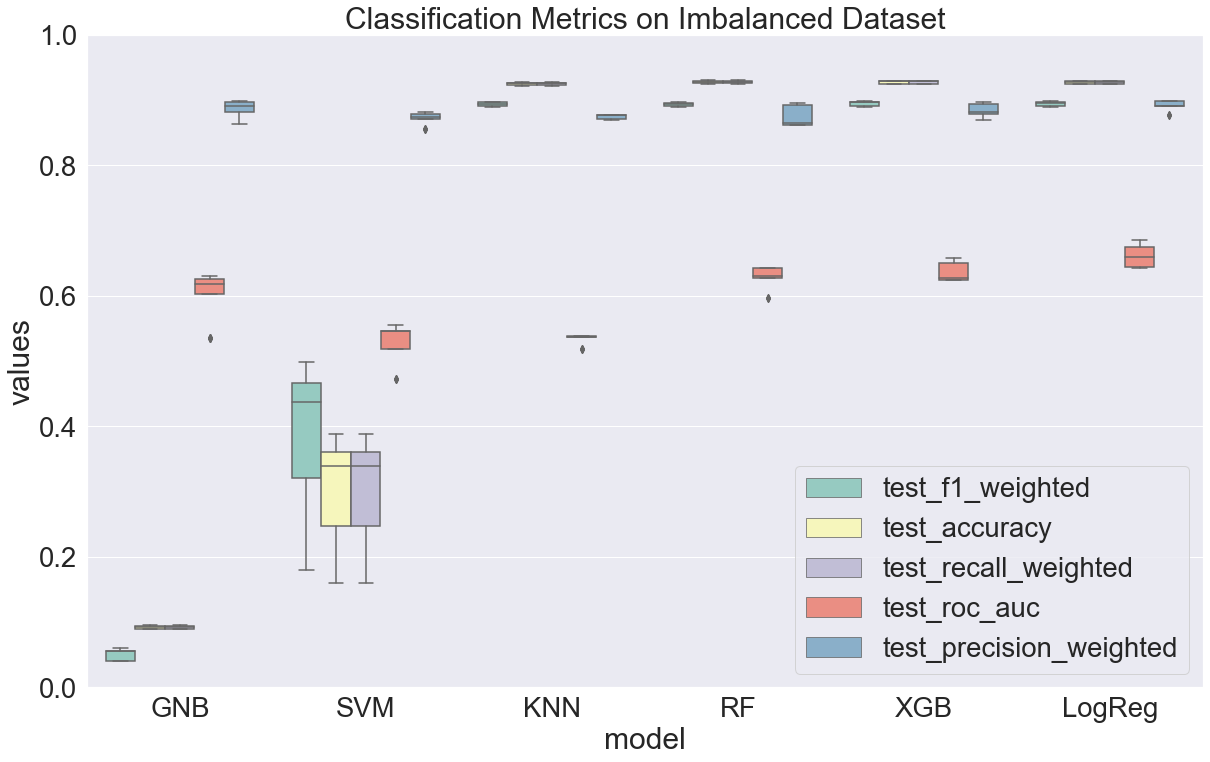

In [125]:

fig = plt.figure(figsize=(20, 12))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", 
                y="values", 
                hue="metrics", 
                data=results_long_nofit, 
                palette="Set3")
#plt.legend(bbox_to_anchor=(1.05, 1),loc='lower center')
plt.ylim(0, 1)

plt.legend(loc='best')
plt.title('Classification Metrics on Imbalanced Dataset')
plt.savefig('./models_perf_imbal.png',dpi=300)


In [92]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])



test_f1_weighted           test_recall_weighted           test_roc_auc  \
                    std      mean                  std      mean          std   
model                                                                           
GNB            0.008298  0.051005             0.002445  0.091952     0.034564   
KNN            0.002801  0.893970             0.001840  0.925641     0.006246   
LogReg         0.003477  0.894781             0.002290  0.927950     0.016871   
RF             0.002921  0.893259             0.002042  0.927895     0.013519   
SVM            0.111436  0.396390             0.080007  0.310216     0.026716   
XGB            0.003550  0.894788             0.002447  0.927612     0.013694   

                 test_accuracy           test_precision_weighted            
            mean           std      mean                     std      mean  
model                                                                       
GNB     0.600670      0.002445  0.091952                0.012710  0.885751  
KNN     0.534746      0.001840  0.925641                0.003057  0.874967  
LogReg  0.658607      0.002290  0.927950                0.006201  0.892838  
RF      0.631287      0.002042  0.927895                0.014696  0.873463  
SVM     0.532544      0.080007  0.310216                0.008137  0.874377  
XGB     0.635292      0.002447  0.927612                0.009190  0.884402

In [93]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])


fit_time            score_time           
             std       mean        std       mean
model                                            
GNB     0.006688   0.150104   0.010679   0.078552
KNN     0.003480   0.041542   0.967756  23.157146
LogReg  0.805132  10.247318   0.001675   0.042487
RF      0.090956   6.912969   0.017000   0.702450
SVM     0.205801  13.519547   0.613888  15.517291
XGB     1.359886   9.879973   0.004634   0.098717

In [ ]:
# BALANCED DATASET

In [109]:
def run_exps(x_train: pd.DataFrame,
             y_train: pd.DataFrame,
             x_test: pd.DataFrame, 
             y_test: pd.DataFrame) -> pd.DataFrame:
    '''
    Lightweight script to test many models and find winners
    :param X_train: training split
    :param y_train: training target vector
    :param X_test: test split
    :param y_test: test target vector
    :return: DataFrame of predictions
    '''
    
    dfs = []
    models = [
        ('LogReg', LogisticRegression(solver='lbfgs', max_iter=1400)),
        ('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier()),
        ('SVM', SVC(max_iter=1400)), 
        ('GNB', GaussianNB()),
        ('XGB', XGBClassifier())]
    
    results = []
    names = []
    scoring = ['accuracy', 
               'precision_weighted', 
               'recall_weighted', 
               'f1_weighted', 
               'roc_auc']
    
    target_names = ['0', '1']
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, 
                                      shuffle=True, 
                                      random_state=90210)
        
        cv_results = model_selection.cross_validate(model, 
                                                    x_train_bal, 
                                                    np.ravel(y_train_bal, order='C'), 
                                                    cv=kfold, 
                                                    scoring=scoring)
        
        clf = model.fit(x_train_bal, 
                        np.ravel(y_train_bal, order='C'))
        y_pred_bal = clf.predict(x_test_bal)
        
        print(name)
        print(classification_report(y_test_bal, y_pred_bal, 
                                    target_names=target_names))
        
        results.append(cv_results)
        names.append(name)
        
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
        
        final_bal = pd.concat(dfs, ignore_index=True)
        final_bal.to_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/models_res_bal.csv')
        
    return final_bal


In [110]:
run_exps(x_train_bal,y_train_bal,
        x_test_bal,y_test_bal)


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

LogReg
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      6483
           1       0.98      0.90      0.94      6440

    accuracy                           0.94     12923
   macro avg       0.94      0.94      0.94     12923
weighted avg       0.94      0.94      0.94     12923

RF
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      6483
           1       0.99      0.92      0.96      6440

    accuracy                           0.96     12923
   macro avg       0.96      0.96      0.96     12923
weighted avg       0.96      0.96      0.96     12923

KNN
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      6483
           1       0.71      1.00      0.83      6440

    accuracy                           0.79     12923
   macro avg       0.85      0.79      0.79     12923
weighted avg       0.85      0.79      0.79     12923



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'
/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1400).  Consider pre-pro

SVM
              precision    recall  f1-score   support

           0       0.52      0.75      0.62      6483
           1       0.56      0.31      0.40      6440

    accuracy                           0.53     12923
   macro avg       0.54      0.53      0.51     12923
weighted avg       0.54      0.53      0.51     12923

GNB
              precision    recall  f1-score   support

           0       0.91      0.33      0.48      6483
           1       0.59      0.97      0.73      6440

    accuracy                           0.65     12923
   macro avg       0.75      0.65      0.61     12923
weighted avg       0.75      0.65      0.60     12923



/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:19:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:10] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:26] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:20:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:21:00] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/alighterness/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:21:17] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6483
           1       0.98      0.91      0.94      6440

    accuracy                           0.95     12923
   macro avg       0.95      0.95      0.95     12923
weighted avg       0.95      0.95      0.95     12923



,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,18.866533,0.070153,0.936451,0.939417,0.936451,0.936299,0.961422,LogReg
1,18.217501,0.070665,0.939159,0.942396,0.939159,0.939067,0.964447,LogReg
2,19.993674,0.071245,0.940994,0.943720,0.940994,0.940889,0.965055,LogReg
3,20.371500,0.103905,0.939253,0.942074,0.939253,0.939171,0.963670,LogReg
4,19.607104,0.065624,0.934223,0.937735,0.934223,0.934127,0.961344,LogReg
5,17.058236,1.551961,0.955603,0.958085,0.955603,0.955515,0.976707,RF
6,16.770369,1.503086,0.956764,0.959371,0.956764,0.956714,0.977882,RF
7,17.433090,1.809120,0.956278,0.958485,0.956278,0.956215,0.977215,RF
8,17.038850,1.591623,0.955407,0.957694,0.955407,0.955361,0.978521,RF
9,16.519956,1.496522,0.952070,0.955136,0.952070,0.952013,0.975143,RF


In [111]:
models_res_bal = pd.read_csv(r'/Users/alighterness/2021/DSc Projects/Hosp_ReAdm_Imbal/models_res_bal.csv')

In [115]:
#models_res_bal = models_res_bal.drop('Unnamed: 0',1)

In [116]:
# evaluate models results
bootstraps_bal = []
for model in list(set(models_res_bal.model.values)):
    model_df = models_res_bal.loc[models_res_bal.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps_bal.append(bootstrap)
        
bootstrap_df_bal = pd.concat(bootstraps_bal, ignore_index=True)
res_long_bal = pd.melt(bootstrap_df_bal,
                       id_vars=['model'],
                       var_name='metrics', 
                       value_name='values')
time_metrics_bal = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit_bal = res_long_bal.loc[~res_long_bal['metrics'].isin(time_metrics_bal)] # get df without fit data
results_long_nofit_bal = results_long_nofit_bal.sort_values(by='values')

## TIME METRICS
results_long_fit_bal = res_long_bal.loc[res_long_bal['metrics'].isin(time_metrics_bal)] # df with fit data
results_long_fit_bal = results_long_fit_bal.sort_values(by='values')


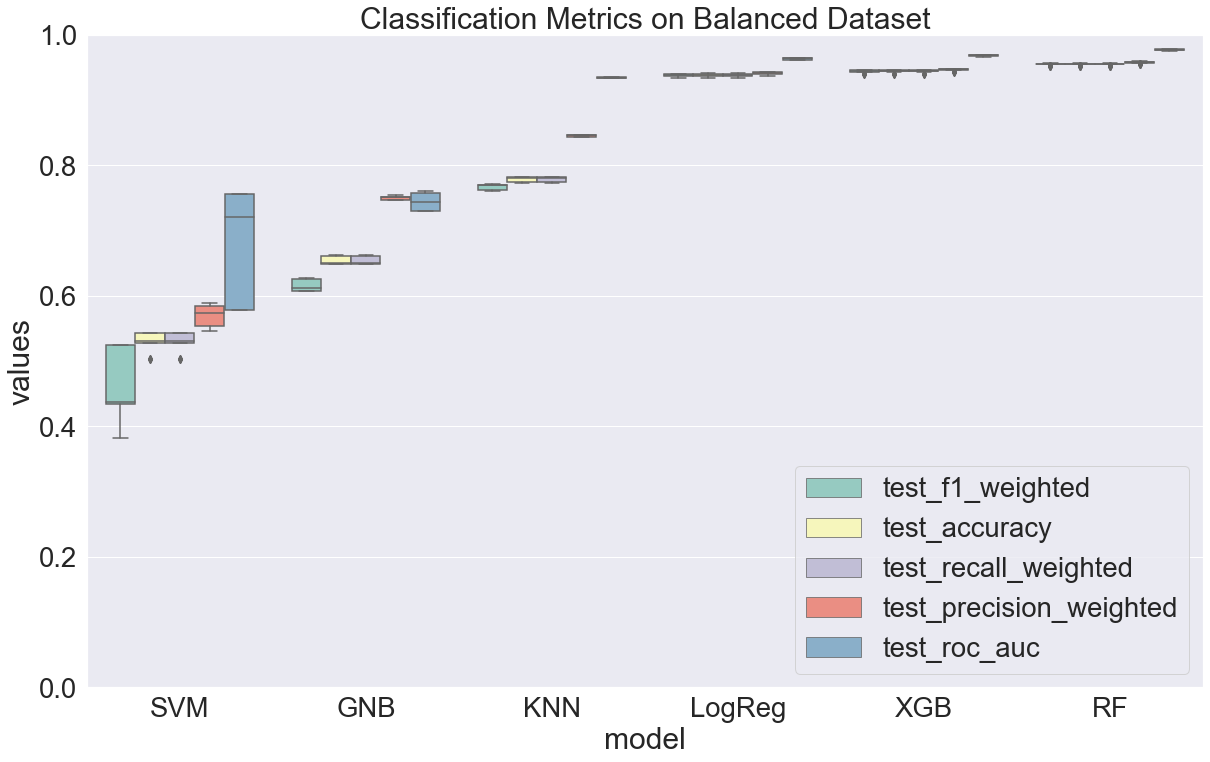

In [124]:

fig = plt.figure(figsize=(20, 12))
#sns.set(font_scale=2.5)
g = sns.boxplot(x="model", 
                y="values", 
                hue="metrics", 
                data=results_long_nofit_bal, 
                palette="Set3")
#plt.legend(bbox_to_anchor=(1.05, 1),loc='lower center')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.title('Classification Metrics on Balanced Dataset')
plt.savefig('./models_perf_bal.png',dpi=300)


In [118]:
metrics_bal = list(set(results_long_nofit_bal.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])


test_f1_weighted           test_recall_weighted           test_roc_auc  \
                    std      mean                  std      mean          std   
model                                                                           
GNB            0.008298  0.051005             0.002445  0.091952     0.034564   
KNN            0.002801  0.893970             0.001840  0.925641     0.006246   
LogReg         0.003477  0.894781             0.002290  0.927950     0.016871   
RF             0.002921  0.893259             0.002042  0.927895     0.013519   
SVM            0.111436  0.396390             0.080007  0.310216     0.026716   
XGB            0.003550  0.894788             0.002447  0.927612     0.013694   

                 test_accuracy           test_precision_weighted            
            mean           std      mean                     std      mean  
model                                                                       
GNB     0.600670      0.002445  0.091952                0.012710  0.885751  
KNN     0.534746      0.001840  0.925641                0.003057  0.874967  
LogReg  0.658607      0.002290  0.927950                0.006201  0.892838  
RF      0.631287      0.002042  0.927895                0.014696  0.873463  
SVM     0.532544      0.080007  0.310216                0.008137  0.874377  
XGB     0.635292      0.002447  0.927612                0.009190  0.884402

In [119]:
time_metrics_bal = list(set(results_long_fit_bal.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics_bal].agg([np.std, np.mean])


fit_time            score_time           
             std       mean        std       mean
model                                            
GNB     0.006688   0.150104   0.010679   0.078552
KNN     0.003480   0.041542   0.967756  23.157146
LogReg  0.805132  10.247318   0.001675   0.042487
RF      0.090956   6.912969   0.017000   0.702450
SVM     0.205801  13.519547   0.613888  15.517291
XGB     1.359886   9.879973   0.004634   0.098717

## 8. Feature Importance

## 9. Results & Discussion

## 10. References 
1. Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore, “Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records,” BioMed Research International, vol. 2014, Article ID 781670, 11 pages, 2014.
2. Ranveer, S. (2020). Diabetes 130 US hospitals for years 1999-2008. Medium. Retrieved from https://medium.com/analytics-vidhya/diabetes-130-us-hospitals-for-years-1999-2008-e18d69beea4d
3. Graham, E., Saxena, A., Kirby, H. (2019). Identifying High Risk Patients for Hospital Readmission. SMU Data Science Review: Vol. 2 : No. 1 , Article 22. Available at: https://scholar.smu.edu/datasciencereview/vol2/iss1/22
4. CHONGCHONG. (2021). Predicting Hospital Readmission of Diabetics. Retrieved from the Kaggle website from https://www.kaggle.com/chongchong33/predicting-hospital-readmission-of-diabetics#5.-Model-Comparison
5. SHARMA, A. (2019). Prediction on Hospital Readmission. Retrieved from Kaggle from https://www.kaggle.com/iabhishekofficial/prediction-on-hospital-readmission
